<a href="https://colab.research.google.com/github/machiwao/CCADMACL_PROJECT_COM222/blob/executive/PART_4_KMeans_CCADMACL_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multidimensinal Poverty Measures
Dataset Reference: https://www.kaggle.com/datasets/grosvenpaul/family-income-and-expenditure/data


In [107]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

In [108]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#Data Loading

In [109]:
df = pd.read_csv('https://raw.githubusercontent.com/machiwao/CCADMACL_PROJECT_COM222/refs/heads/main/Family%20Income%20and%20Expenditure.csv')
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

Dataset loaded with 41544 rows and 60 columns


In [110]:
print("Dataset shape:", df.shape)
print("\nColumns in the dataset:")
print(df.columns.tolist())

Dataset shape: (41544, 60)

Columns in the dataset:
['Total Household Income', 'Region', 'Total Food Expenditure', 'Main Source of Income', 'Agricultural Household indicator', 'Bread and Cereals Expenditure', 'Total Rice Expenditure', 'Meat Expenditure', 'Total Fish and  marine products Expenditure', 'Fruit Expenditure', 'Vegetables Expenditure', 'Restaurant and hotels Expenditure', 'Alcoholic Beverages Expenditure', 'Tobacco Expenditure', 'Clothing, Footwear and Other Wear Expenditure', 'Housing and water Expenditure', 'Imputed House Rental Value', 'Medical Care Expenditure', 'Transportation Expenditure', 'Communication Expenditure', 'Education Expenditure', 'Miscellaneous Goods and Services Expenditure', 'Special Occasions Expenditure', 'Crop Farming and Gardening expenses', 'Total Income from Entrepreneurial Acitivites', 'Household Head Sex', 'Household Head Age', 'Household Head Marital Status', 'Household Head Highest Grade Completed', 'Household Head Job or Business Indicator', '

In [111]:
# Display initial information
print("Initial data information:")
df.info()

Initial data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 60 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Total Household Income                         41544 non-null  int64 
 1   Region                                         41544 non-null  object
 2   Total Food Expenditure                         41544 non-null  int64 
 3   Main Source of Income                          41544 non-null  object
 4   Agricultural Household indicator               41544 non-null  int64 
 5   Bread and Cereals Expenditure                  41544 non-null  int64 
 6   Total Rice Expenditure                         41544 non-null  int64 
 7   Meat Expenditure                               41544 non-null  int64 
 8   Total Fish and  marine products Expenditure    41544 non-null  int64 
 9   Fruit Expenditure                  

In [112]:
# Display summary statistics
print("Summary statistics:")
print(df.describe())

Summary statistics:
       Total Household Income  Total Food Expenditure  \
count            4.154400e+04            41544.000000   
mean             2.475556e+05            85099.158194   
std              2.868805e+05            51637.947682   
min              1.128500e+04             2947.000000   
25%              1.048950e+05            51017.250000   
50%              1.640795e+05            72985.500000   
75%              2.911385e+05           105635.500000   
max              1.181599e+07           827565.000000   

       Agricultural Household indicator  Bread and Cereals Expenditure  \
count                      41544.000000                   41544.000000   
mean                           0.429858                   25133.723642   
std                            0.676666                   13466.482984   
min                            0.000000                       0.000000   
25%                            0.000000                   16556.000000   
50%                   

In [113]:
# Check for missing values and visualize
print("Missing values per column:")
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

Missing values per column:
Household Head Occupation         7536
Household Head Class of Worker    7536
Toilet Facilities                 1580
dtype: int64


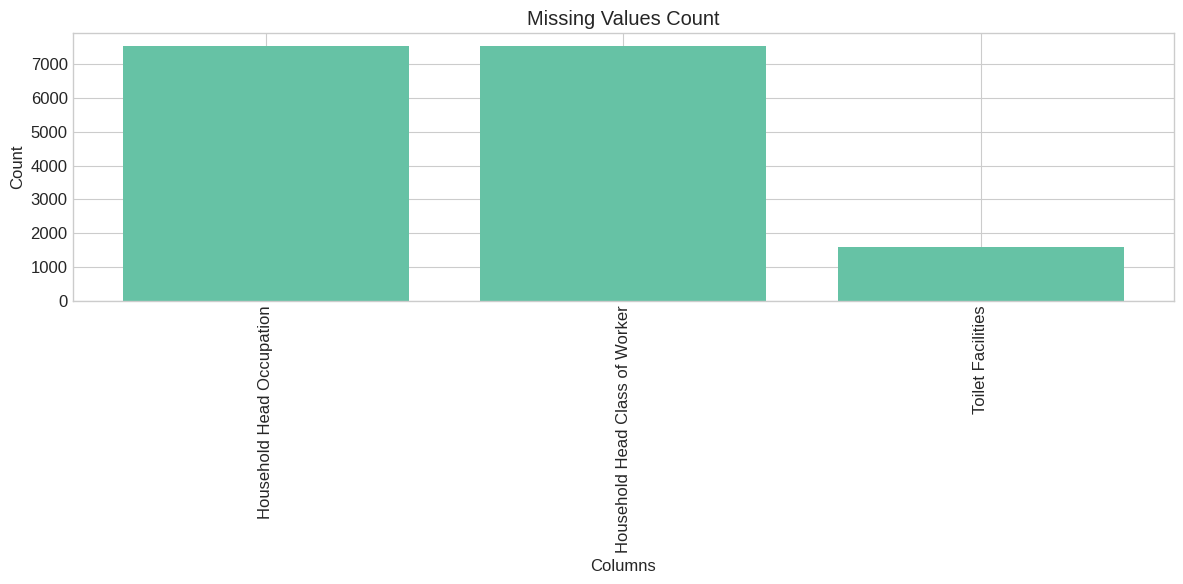

In [114]:
# Visualize missing values if any
if len(missing_values) > 0:
    plt.figure(figsize=(12, 6))
    plt.bar(missing_values.index, missing_values.values)
    plt.xticks(rotation=90)
    plt.title('Missing Values Count')
    plt.xlabel('Columns')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

#Data Cleaning and Preprocessing

In [115]:
# Handle missing values based on column type
# For numerical columns, fill with median
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} with median")
        df[col] = df[col].fillna(df[col].median())

# For categorical columns, fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} with mode")
        df[col] = df[col].fillna(df[col].mode()[0])

# Create Region categorical encoding
region_mapping = {region: idx for idx, region in enumerate(df['Region'].unique())}
df['Region_Code'] = df['Region'].map(region_mapping)

# Create income-related features
df['Income_per_capita'] = df['Total Household Income'] / df['Total Number of Family members']
df['Food_percentage'] = (df['Total Food Expenditure'] / df['Total Household Income']) * 100
df['Housing_percentage'] = (df['Housing and water Expenditure'] / df['Total Household Income']) * 100
df['Education_percentage'] = (df['Education Expenditure'] / df['Total Household Income']) * 100
df['Health_percentage'] = (df['Medical Care Expenditure'] / df['Total Household Income']) * 100

Filling missing values in Household Head Occupation with mode
Filling missing values in Household Head Class of Worker with mode
Filling missing values in Toilet Facilities with mode


In [116]:
# Function to handle outliers using IQR
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    print(f"Column: {column}")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    print(f"  Outliers detected: {outlier_count}")

    # Cap outliers
    if outlier_count > 0:
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        print(f"  Outliers capped at boundaries")

    return df

In [117]:
# Handle outliers for key income and expenditure columns
columns_for_outlier_handling = [
    'Total Household Income',
    'Total Food Expenditure',
    'Housing and water Expenditure',
    'Education Expenditure',
    'Medical Care Expenditure',
    'Transportation Expenditure',
    'Income_per_capita'
]

for col in columns_for_outlier_handling:
    df = handle_outliers_iqr(df, col)

Column: Total Household Income
  Lower bound: -174470.25
  Upper bound: 570503.75
  Outliers detected: 3151
  Outliers capped at boundaries
Column: Total Food Expenditure
  Lower bound: -30910.12
  Upper bound: 187562.88
  Outliers detected: 1849
  Outliers capped at boundaries
Column: Housing and water Expenditure
  Lower bound: -36222.00
  Upper bound: 95250.00
  Outliers detected: 2954
  Outliers capped at boundaries
Column: Education Expenditure
  Lower bound: -6090.00
  Upper bound: 10150.00
  Outliers detected: 7217
  Outliers capped at boundaries
Column: Medical Care Expenditure
  Lower bound: -6270.00
  Upper bound: 11250.00
  Outliers detected: 5413
  Outliers capped at boundaries
Column: Transportation Expenditure
  Lower bound: -14634.00
  Upper bound: 30822.00
  Outliers detected: 3422
  Outliers capped at boundaries
Column: Income_per_capita
  Lower bound: -49287.65
  Upper bound: 146776.96
  Outliers detected: 3356
  Outliers capped at boundaries


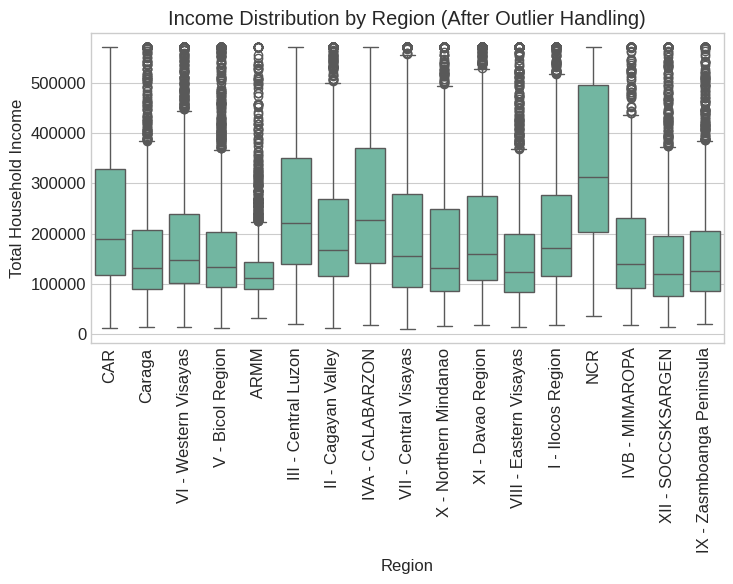

In [118]:
# Visualize income distribution by region before and after outlier handling
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Region', y='Total Household Income', data=df)
plt.xticks(rotation=90)
plt.title('Income Distribution by Region (After Outlier Handling)')
plt.ylabel('Total Household Income')
plt.tight_layout()
plt.show()

#Feature Selection

In [120]:
# Select relevant features for clustering
selected_features = [
    'Total Household Income',
    'Income_per_capita',
    'Total Food Expenditure',
    'Food_percentage',
    'Housing and water Expenditure',
    'Housing_percentage',
    'Education Expenditure',
    'Education_percentage',
    'Medical Care Expenditure',
    'Health_percentage',
    'Transportation Expenditure',
    'Restaurant and hotels Expenditure',
    'Clothing, Footwear and Other Wear Expenditure',
    'Communication Expenditure',
    'Total Number of Family members',
    'Number of Television',
    'Number of Refrigerator/Freezer',
    'Number of Washing Machine',
    'Number of Cellular phone',
    'Number of Personal Computer'
]

# Create feature dataframe
features_df = df[selected_features].copy()
print("Selected features shape:", features_df.shape)
print("Selected features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

Selected features shape: (41544, 20)
Selected features:
1. Total Household Income
2. Income_per_capita
3. Total Food Expenditure
4. Food_percentage
5. Housing and water Expenditure
6. Housing_percentage
7. Education Expenditure
8. Education_percentage
9. Medical Care Expenditure
10. Health_percentage
11. Transportation Expenditure
12. Restaurant and hotels Expenditure
13. Clothing, Footwear and Other Wear Expenditure
14. Communication Expenditure
15. Total Number of Family members
16. Number of Television
17. Number of Refrigerator/Freezer
18. Number of Washing Machine
19. Number of Cellular phone
20. Number of Personal Computer


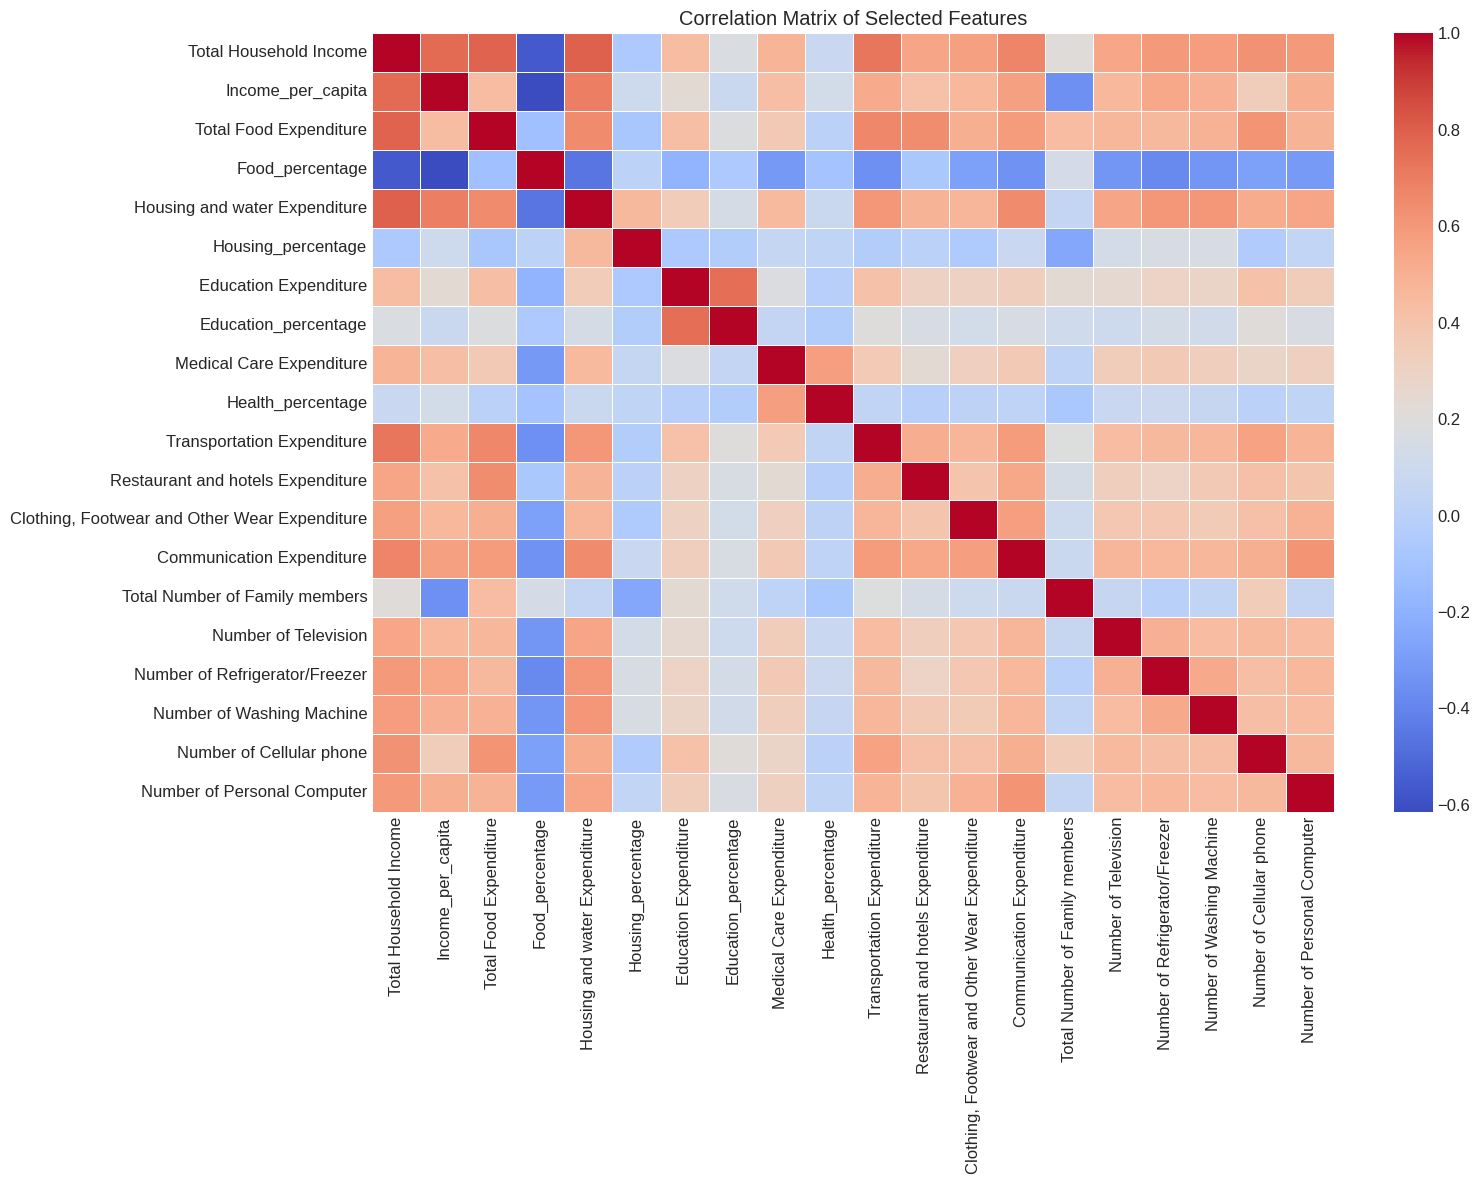

In [121]:
# Visualize correlation between selected features
plt.figure(figsize=(16, 12))
correlation_matrix = features_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()

In [122]:
print("--- DATA NORMALIZATION ---")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_features, columns=features_df.columns)

print("Scaled features summary:")
print(scaled_df.describe().round(2))

--- DATA NORMALIZATION ---
Scaled features summary:
       Total Household Income  Income_per_capita  Total Food Expenditure  \
count                41544.00           41544.00                41544.00   
mean                     0.00               0.00                   -0.00   
std                      1.00               1.00                    1.00   
min                     -1.35              -1.28                   -1.86   
25%                     -0.74              -0.76                   -0.74   
50%                     -0.36              -0.36                   -0.23   
75%                      0.47               0.46                    0.53   
max                      2.29               2.28                    2.44   

       Food_percentage  Housing and water Expenditure  Housing_percentage  \
count         41544.00                       41544.00            41544.00   
mean             -0.00                          -0.00               -0.00   
std               1.00          

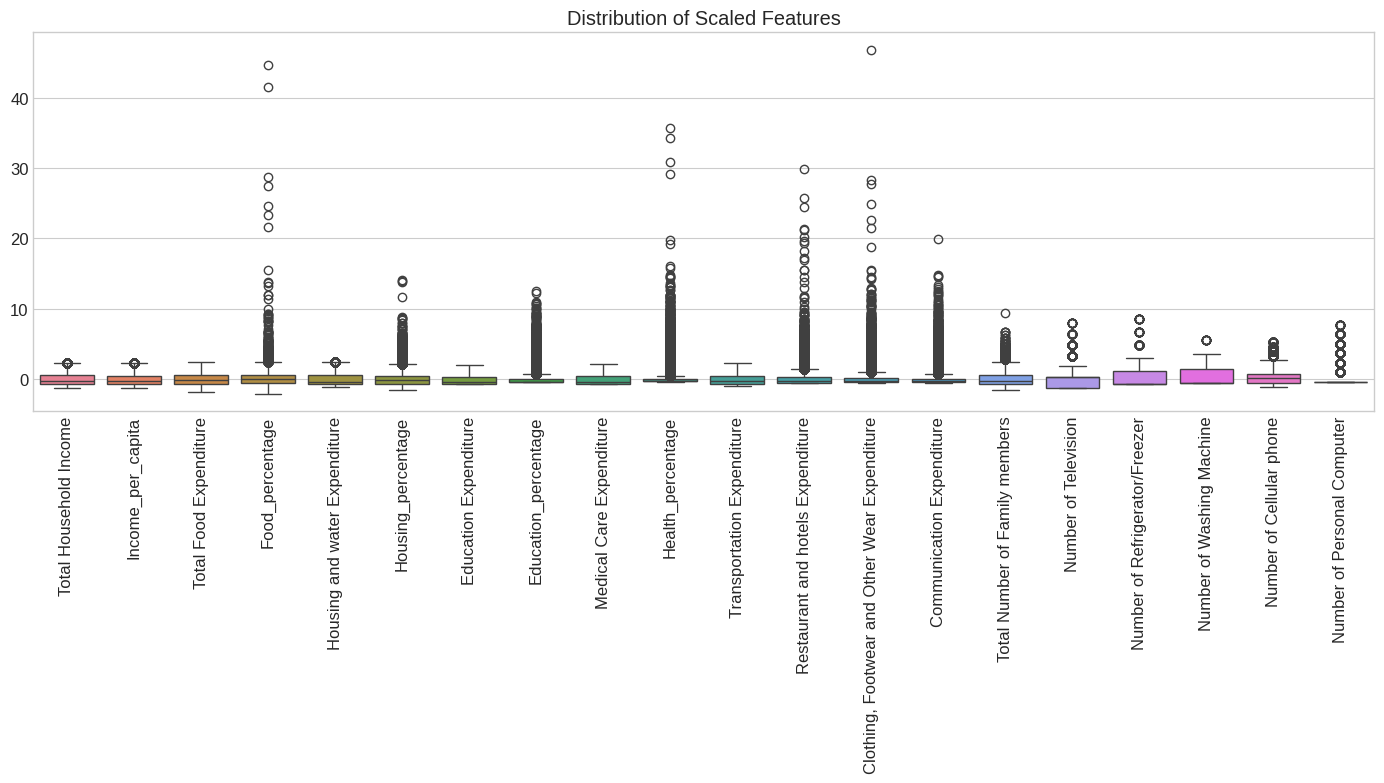

In [123]:
# Visualize distribution of scaled features
plt.figure(figsize=(14, 8))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.title('Distribution of Scaled Features')
plt.tight_layout()
plt.show()

#PCA

In [125]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)  # Targeting 2-3 components as requested
pca_result = pca.fit_transform(scaled_features)

In [126]:
# Print explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Explained variance ratio by component:")
for i, var in enumerate(explained_variance, 1):
    print(f"PC{i}: {var:.4f} ({cumulative_variance[i-1]:.4f} cumulative)")

# Create PCA dataframe for visualization
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Region'] = df['Region'].values

Explained variance ratio by component:
PC1: 0.4049 (0.4049 cumulative)
PC2: 0.1055 (0.5104 cumulative)
PC3: 0.0689 (0.5793 cumulative)


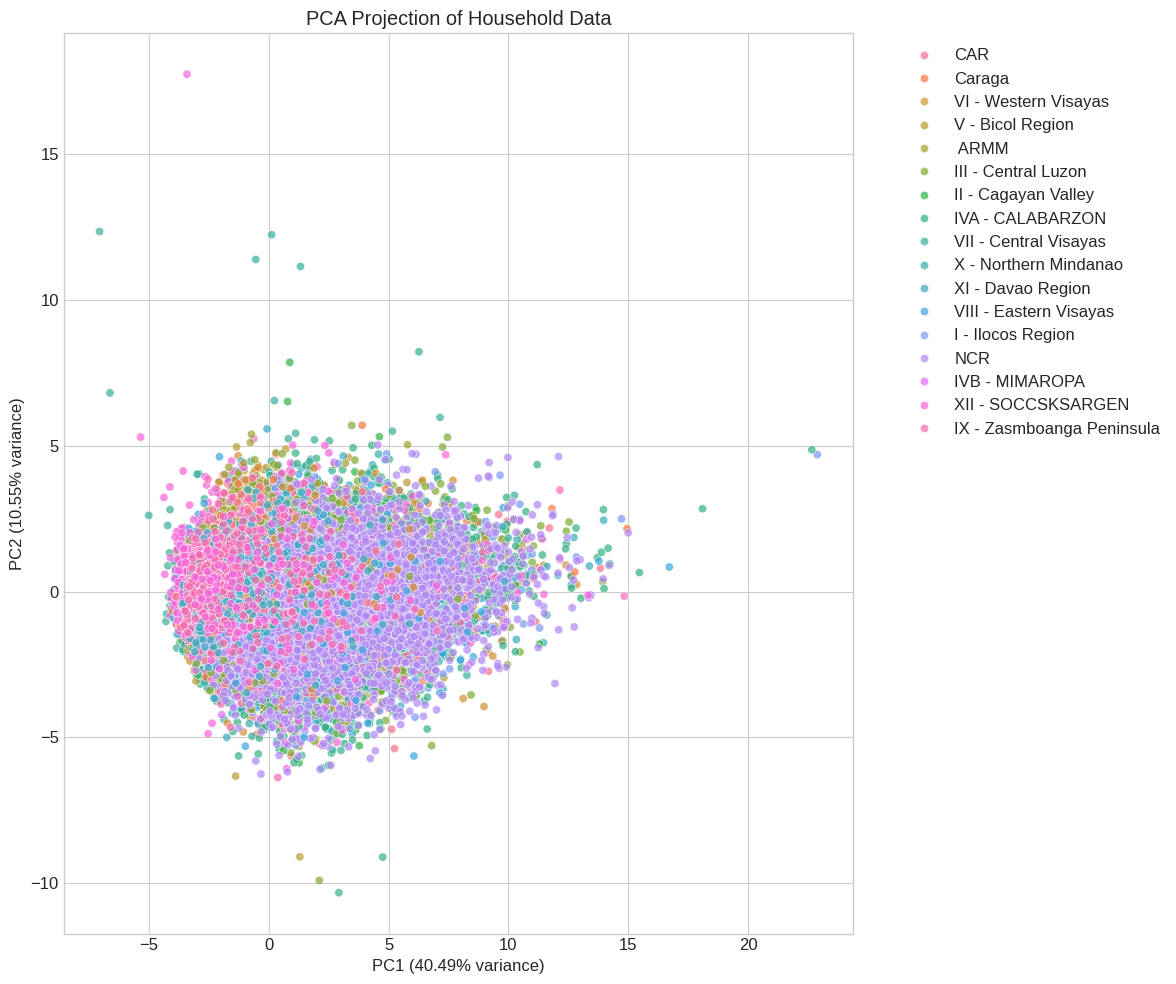

In [127]:
# Visualize PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Region', data=pca_df, alpha=0.7)
plt.title('PCA Projection of Household Data')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

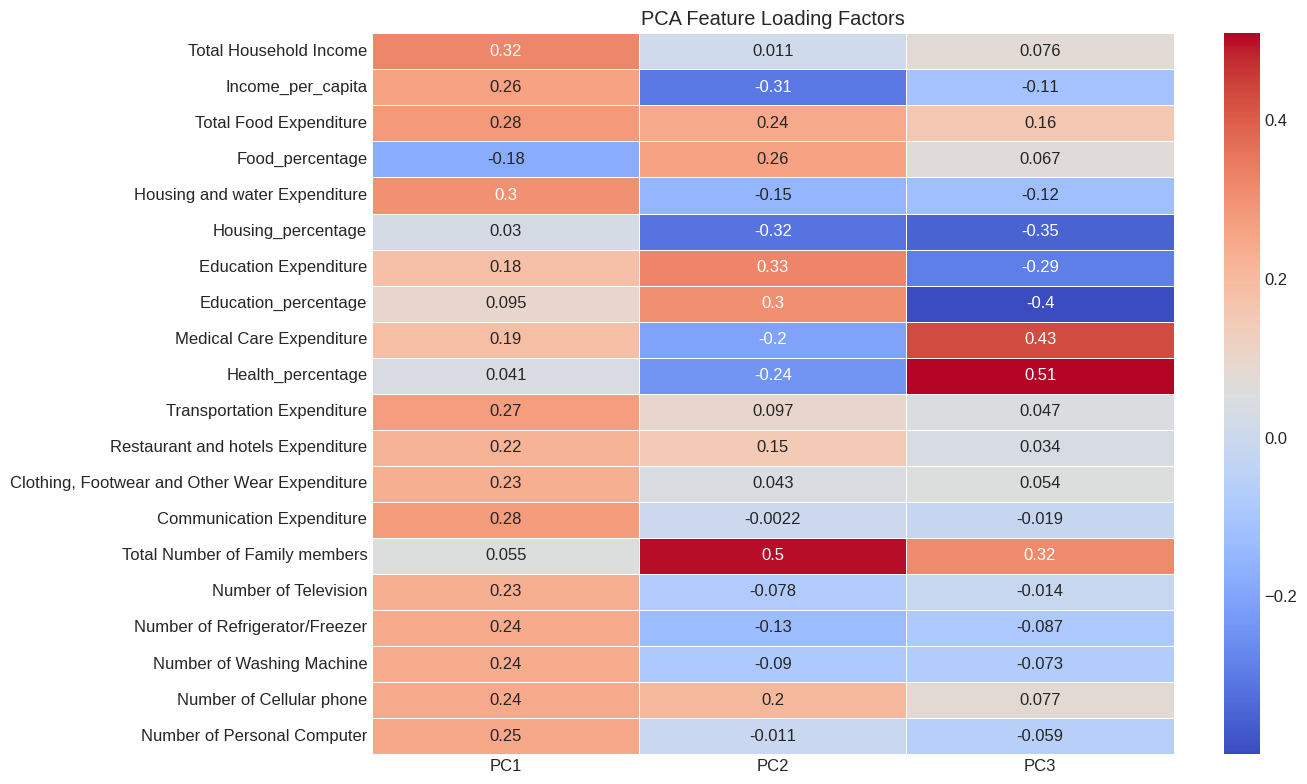

In [128]:
# Visualize PCA loading factors
plt.figure(figsize=(14, 8))
loading_factors = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=features_df.columns
)
sns.heatmap(loading_factors, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('PCA Feature Loading Factors')
plt.tight_layout()
plt.show()

#KMeans Clustering

In [129]:
# Determine optimal number of clusters using silhouette scores
silhouette_scores = []
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_result)
    silhouette_avg = silhouette_score(pca_result, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    inertia_values.append(kmeans.inertia_)
    print(f"Clusters: {k}, Silhouette Score: {silhouette_avg:.4f}, Inertia: {kmeans.inertia_:.2f}")

Clusters: 2, Silhouette Score: 0.4867, Inertia: 246738.53
Clusters: 3, Silhouette Score: 0.3584, Inertia: 194989.55
Clusters: 4, Silhouette Score: 0.3419, Inertia: 164762.46
Clusters: 5, Silhouette Score: 0.2939, Inertia: 145586.62
Clusters: 6, Silhouette Score: 0.2464, Inertia: 131448.92
Clusters: 7, Silhouette Score: 0.2563, Inertia: 119245.46
Clusters: 8, Silhouette Score: 0.2547, Inertia: 109745.55
Clusters: 9, Silhouette Score: 0.2657, Inertia: 101223.59
Clusters: 10, Silhouette Score: 0.2658, Inertia: 94896.21


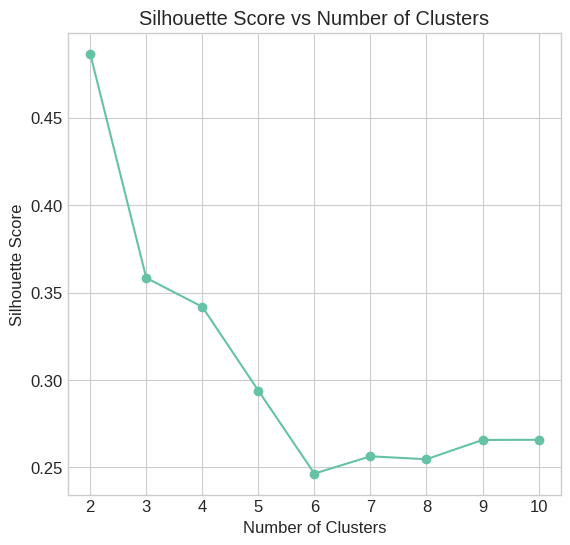

In [130]:
# Visualize silhouette scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

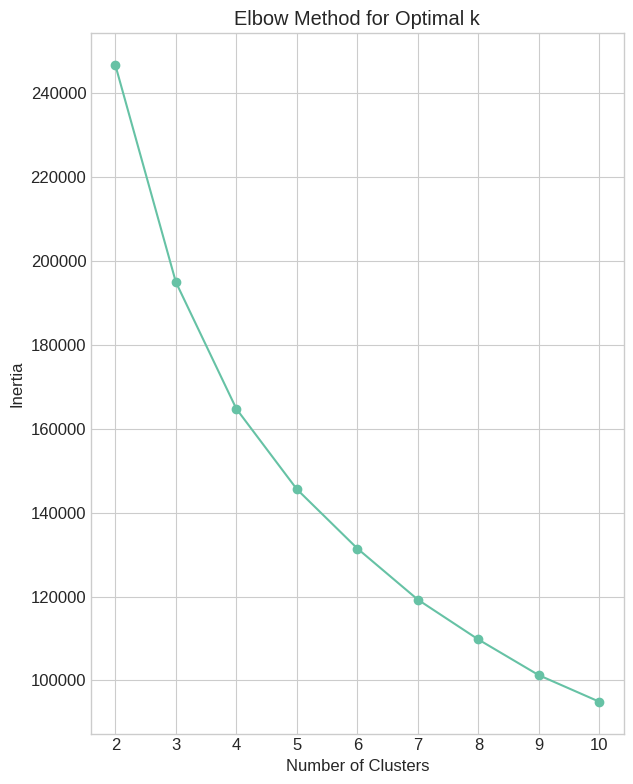

In [131]:
# Visualize inertia (elbow method)
plt.subplot(1, 2, 2)
plt.plot(k_range, inertia_values, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [133]:
# Select optimal number of clusters based on silhouette score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Maximum silhouette score: {max(silhouette_scores):.4f}")

Optimal number of clusters based on silhouette score: 2
Maximum silhouette score: 0.4867


In [134]:
# Apply K-means with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_result)

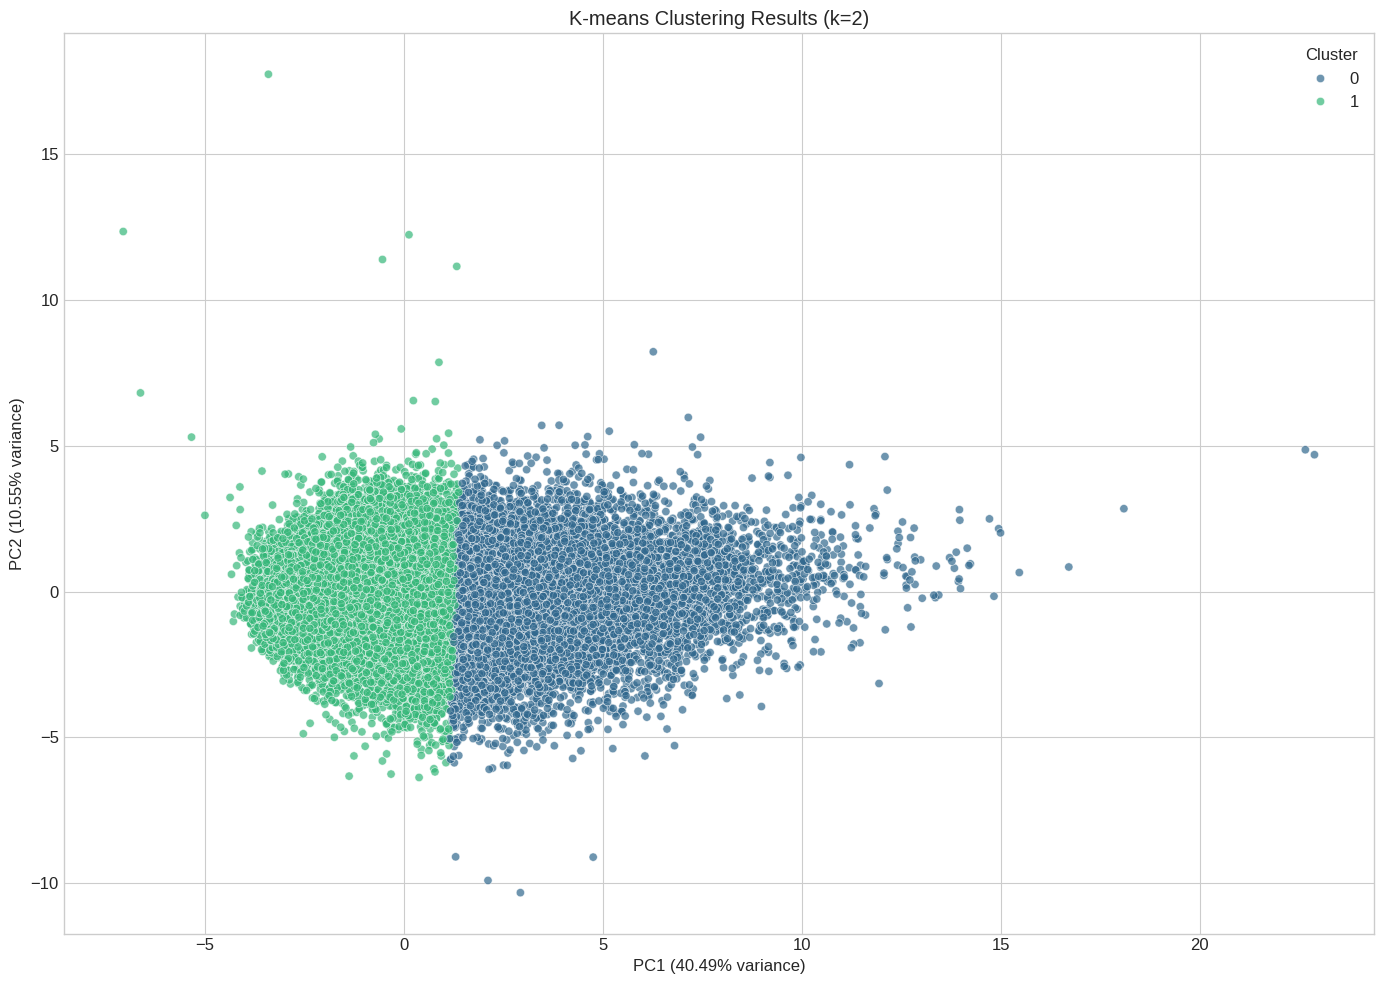

In [135]:
# Add cluster labels to the original dataframe
df['Cluster'] = clusters
pca_df['Cluster'] = clusters

# Visualize clusters in PCA space
plt.figure(figsize=(14, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, alpha=0.7)
plt.title(f'K-means Clustering Results (k={optimal_k})')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.tight_layout()
plt.show()

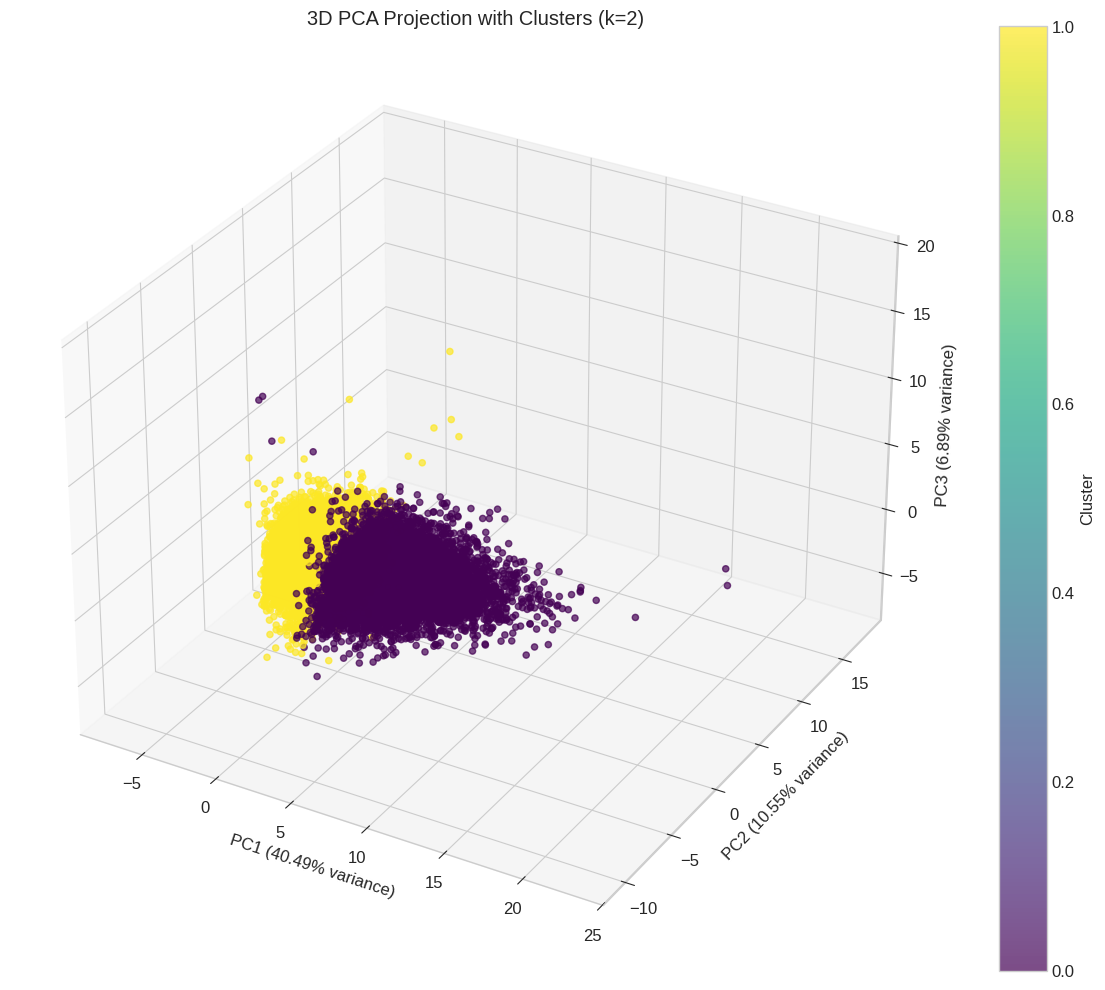

In [136]:
# Visualize 3D PCA with clusters if needed
# This provides an additional perspective on the clustering
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                     c=pca_df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
ax.set_zlabel(f'PC3 ({explained_variance[2]:.2%} variance)')
plt.title(f'3D PCA Projection with Clusters (k={optimal_k})')
plt.tight_layout()
plt.show()

In [137]:
# Calculate and display silhouette score for the optimal clustering
final_silhouette = silhouette_score(pca_result, clusters)
print(f"Final Silhouette Score: {final_silhouette:.4f}")

Final Silhouette Score: 0.4867


#Cluster Profiling

<Figure size 1600x800 with 0 Axes>

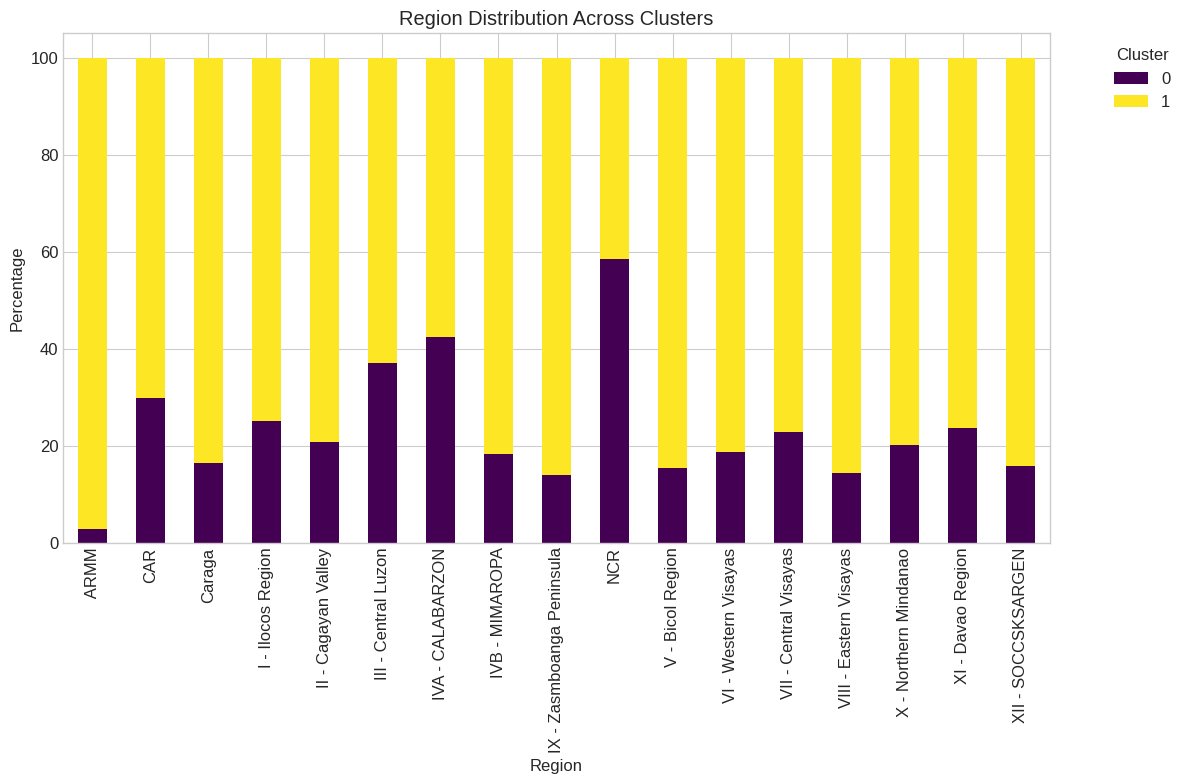

In [138]:
# Map clusters to regions for analysis
region_cluster_df = df[['Region', 'Cluster']].copy()
region_cluster_counts = region_cluster_df.groupby(['Region', 'Cluster']).size().unstack(fill_value=0)
region_cluster_percentage = region_cluster_counts.div(region_cluster_counts.sum(axis=1), axis=0) * 100

# Visualize region distribution across clusters
plt.figure(figsize=(16, 8))
region_cluster_percentage.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Region Distribution Across Clusters')
plt.xlabel('Region')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [139]:
# Generate cluster profiles
cluster_profiles = df.groupby('Cluster').agg({
    'Total Household Income': 'mean',
    'Income_per_capita': 'mean',
    'Total Food Expenditure': 'mean',
    'Housing and water Expenditure': 'mean',
    'Education Expenditure': 'mean',
    'Medical Care Expenditure': 'mean',
    'Transportation Expenditure': 'mean',
    'Restaurant and hotels Expenditure': 'mean',
    'Communication Expenditure': 'mean',
    'Total Number of Family members': 'mean',
    'Household Head Age': 'mean',
    'Food_percentage': 'mean',
    'Housing_percentage': 'mean',
    'Education_percentage': 'mean',
    'Health_percentage': 'mean'
}).round(2)

print("Cluster profiles (means):")
print(cluster_profiles)

Cluster profiles (means):
         Total Household Income  Income_per_capita  Total Food Expenditure  \
Cluster                                                                      
0                     428310.65           99126.01               130099.86   
1                     144317.88           39106.03                65829.25   

         Housing and water Expenditure  Education Expenditure  \
Cluster                                                         
0                             66648.93                5607.55   
1                             21299.11                1857.01   

         Medical Care Expenditure  Transportation Expenditure  \
Cluster                                                         
0                         6074.97                    19911.46   
1                         2090.21                     5919.75   

         Restaurant and hotels Expenditure  Communication Expenditure  \
Cluster                                                           

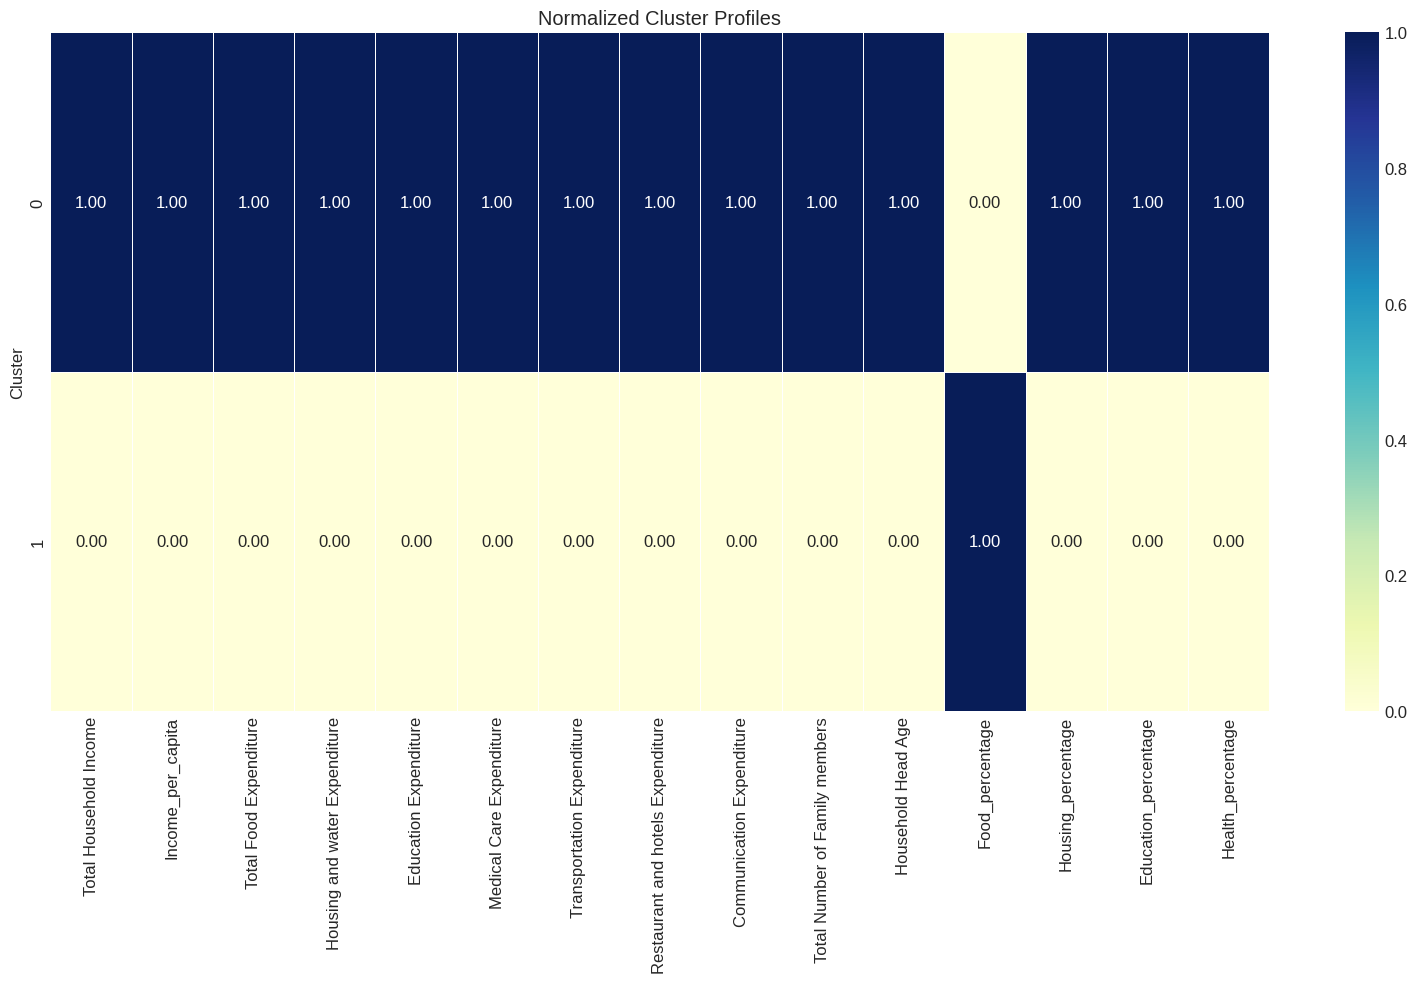

In [140]:
# Generate normalized profiles for easier comparison
min_max_scaler = MinMaxScaler()
normalized_profiles = pd.DataFrame(
    min_max_scaler.fit_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Visualize cluster profiles
plt.figure(figsize=(16, 10))
sns.heatmap(normalized_profiles, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Normalized Cluster Profiles')
plt.tight_layout()
plt.show()

In [141]:
# Create radar charts for each cluster profile
categories = [
    'Income', 'Income per Capita', 'Food Expenditure',
    'Housing Expenditure', 'Education Expenditure', 'Health Expenditure',
    'Transportation Expenditure', 'Restaurant Expenditure'
]

# Prepare data for radar chart
radar_data = cluster_profiles[[
    'Total Household Income', 'Income_per_capita', 'Total Food Expenditure',
    'Housing and water Expenditure', 'Education Expenditure', 'Medical Care Expenditure',
    'Transportation Expenditure', 'Restaurant and hotels Expenditure'
]].copy()

# Normalize data for radar chart
radar_data = pd.DataFrame(
    min_max_scaler.fit_transform(radar_data),
    columns=radar_data.columns,
    index=radar_data.index
)

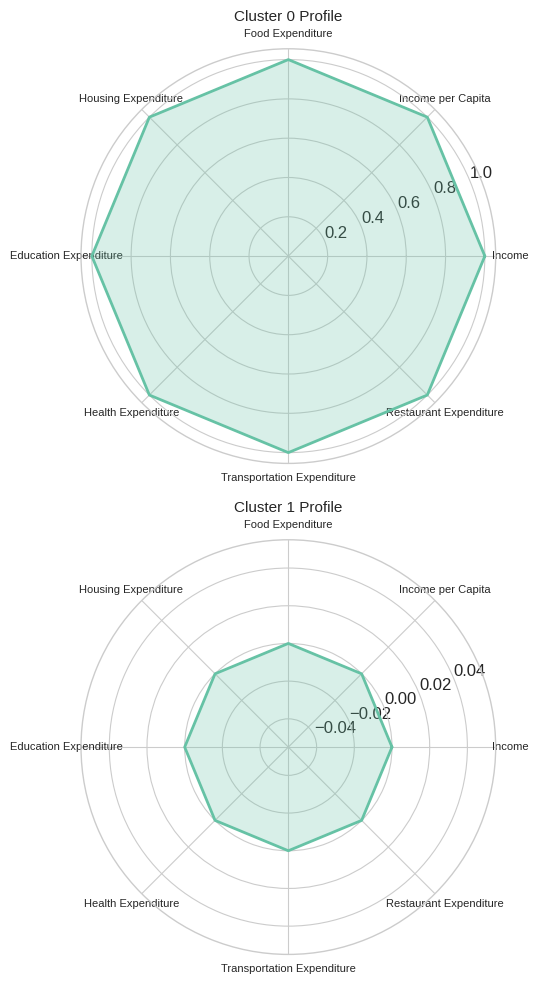

In [142]:
# Create radar chart
fig = plt.figure(figsize=(15, 10))
for i, cluster in enumerate(radar_data.index):
    # Number of variables
    N = len(categories)

    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create subplot
    ax = plt.subplot(2, (optimal_k + 1) // 2, i + 1, polar=True)

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=8)

    # Plot data
    values = radar_data.iloc[i].values.flatten().tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

    # Add title
    plt.title(f'Cluster {cluster} Profile', size=11, pad=20)

plt.tight_layout()
plt.show()

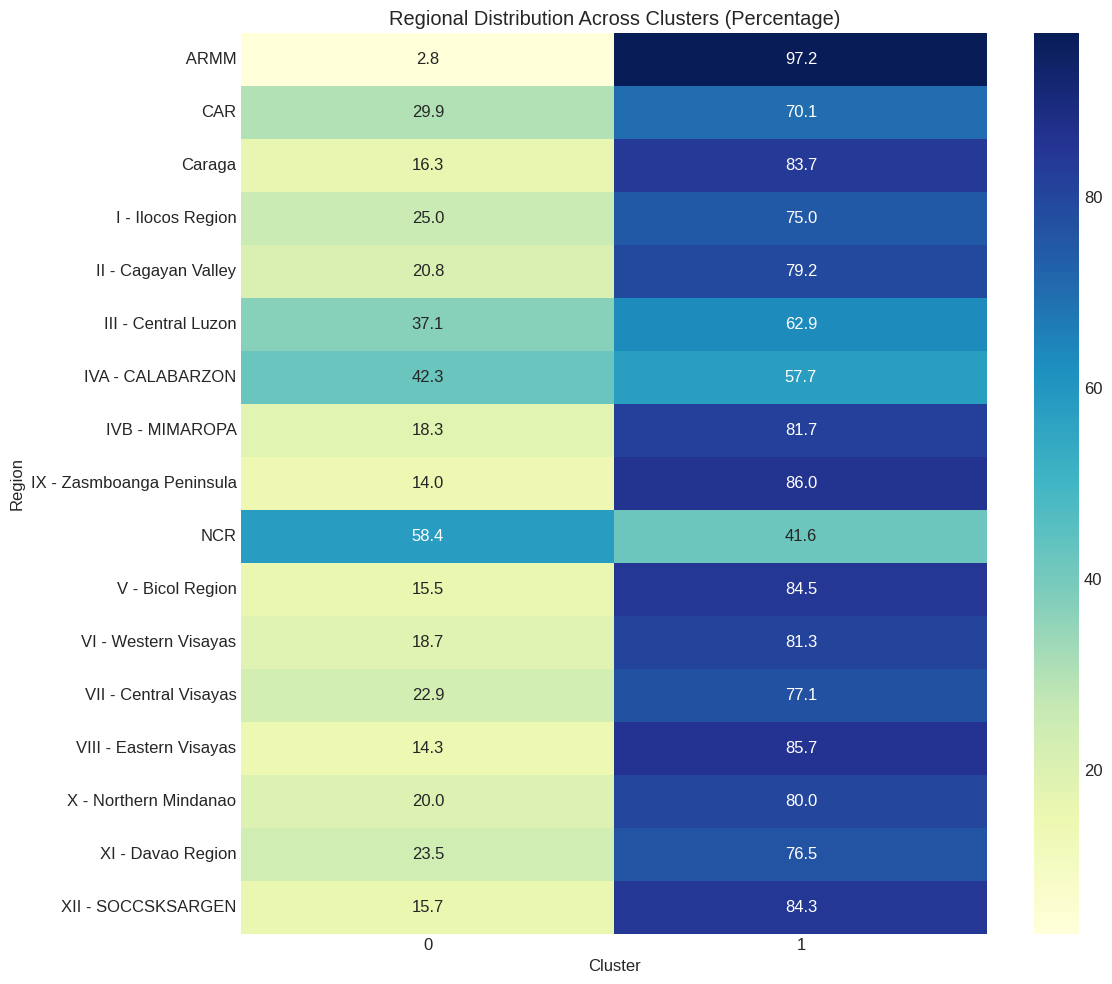

In [143]:
# Regional distribution visualization
region_cluster_map = pd.crosstab(df['Region'], df['Cluster'])
region_cluster_pct = pd.crosstab(df['Region'], df['Cluster'], normalize='index') * 100

# Visualize as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(region_cluster_pct, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Regional Distribution Across Clusters (Percentage)')
plt.tight_layout()
plt.show()

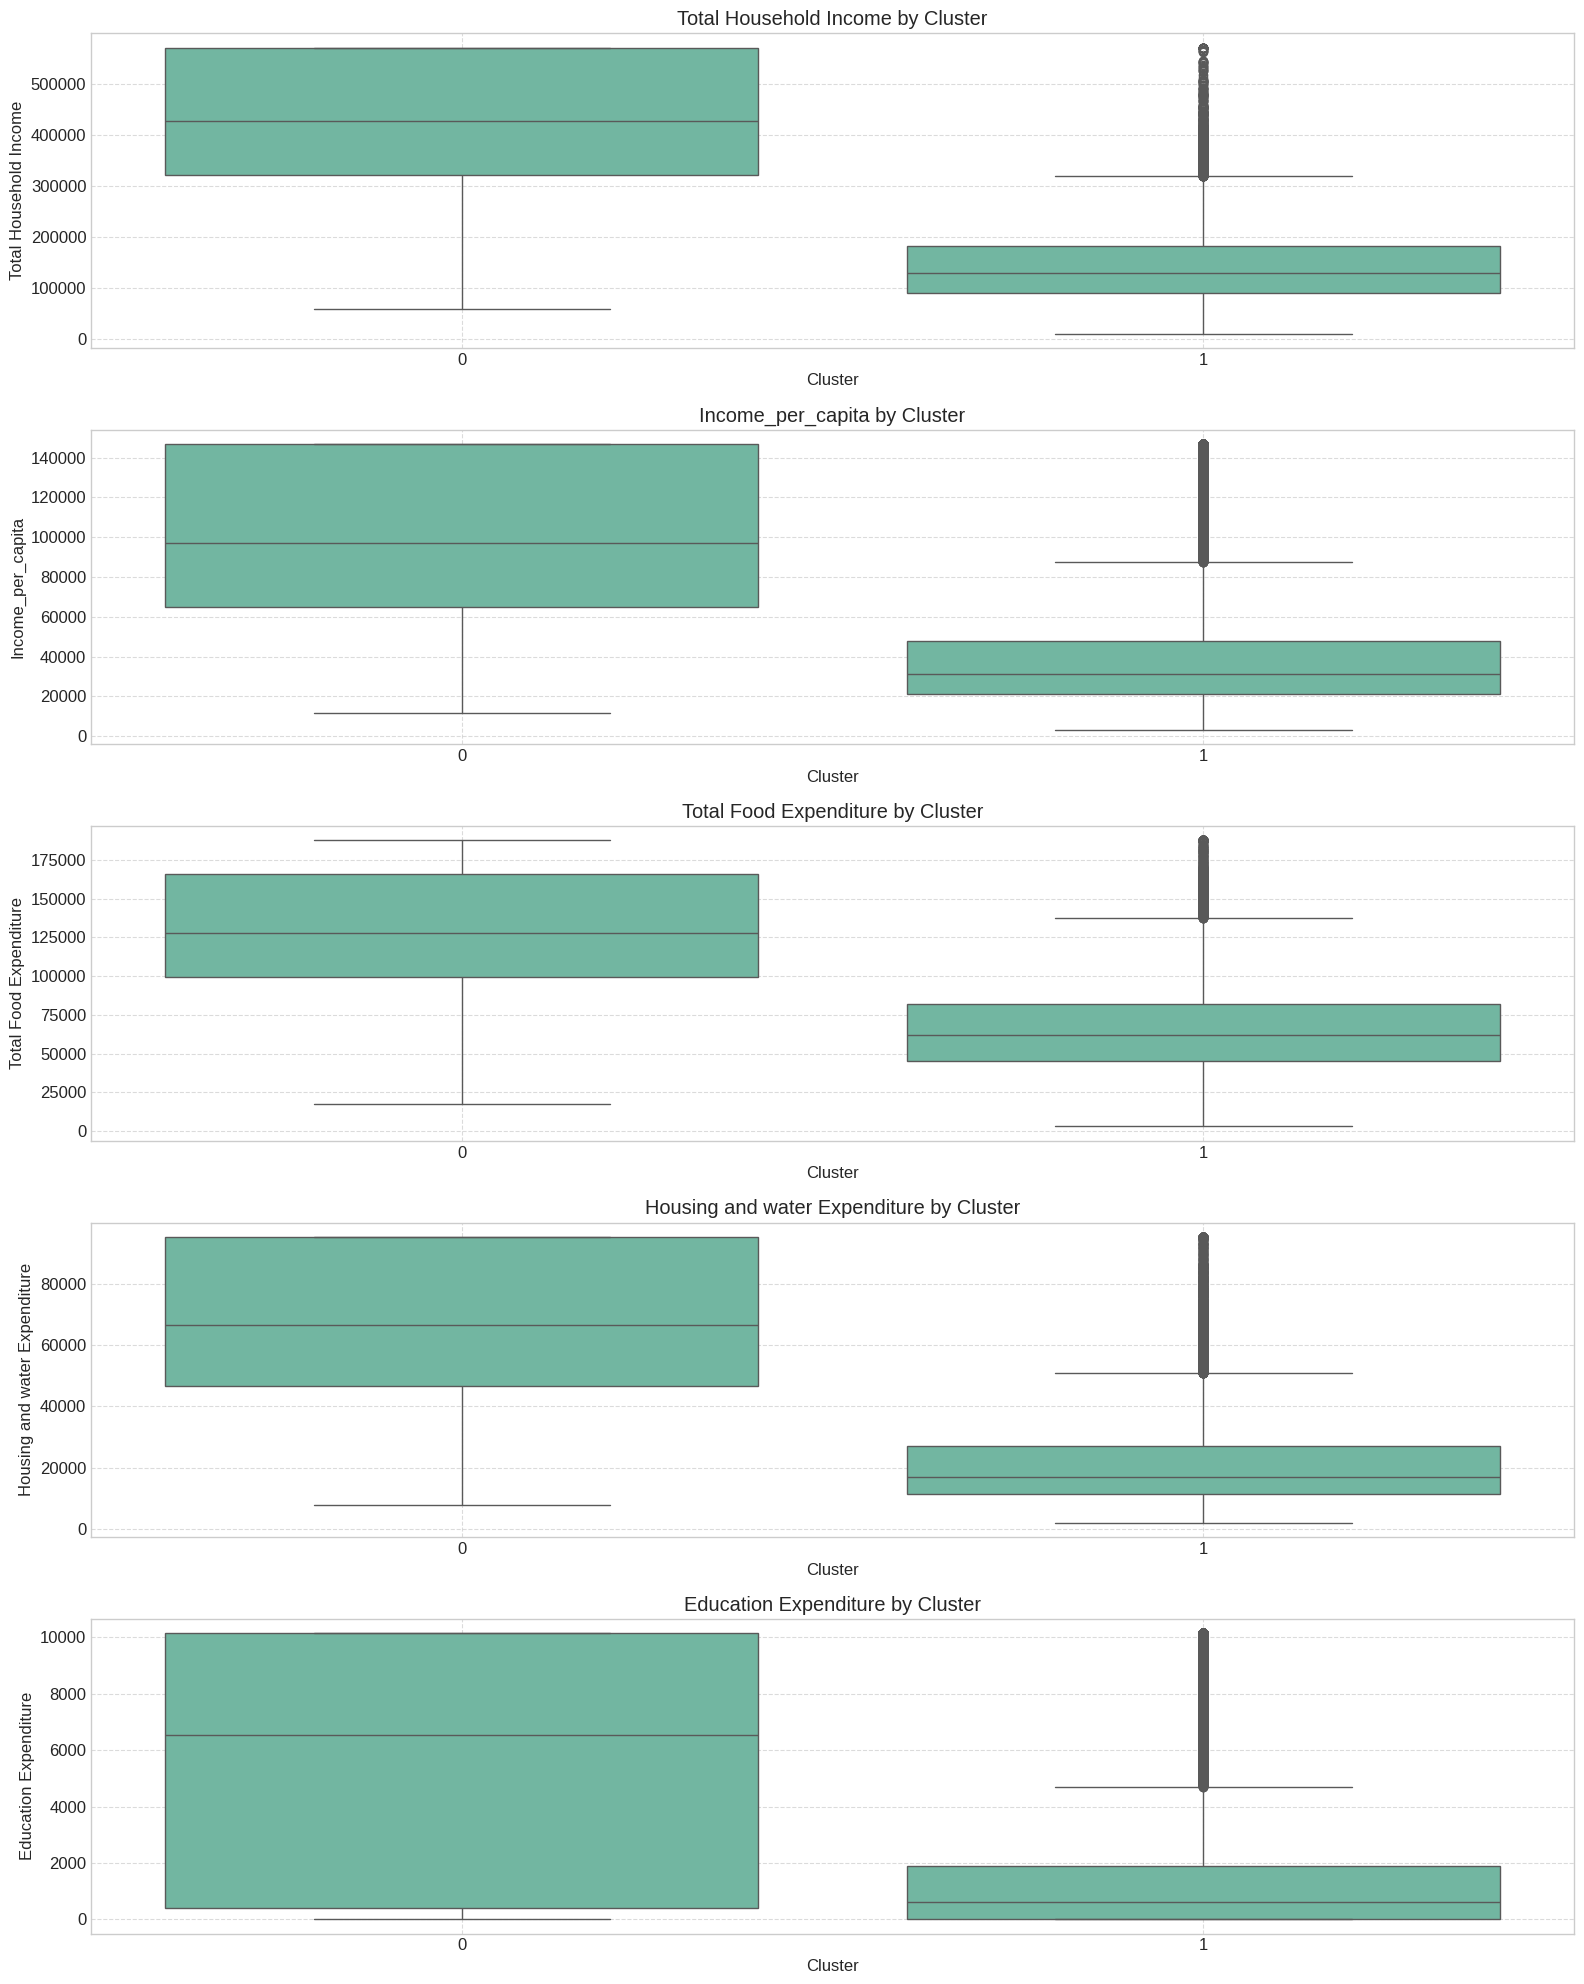

In [144]:
# Boxplots for key metrics by cluster
key_metrics = [
    'Total Household Income',
    'Income_per_capita',
    'Total Food Expenditure',
    'Housing and water Expenditure',
    'Education Expenditure'
]

plt.figure(figsize=(16, 20))
for i, metric in enumerate(key_metrics, 1):
    plt.subplot(len(key_metrics), 1, i)
    sns.boxplot(x='Cluster', y=metric, data=df)
    plt.title(f'{metric} by Cluster')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [145]:
# Summary statistics by cluster
print("\n--- DETAILED CLUSTER SUMMARY ---")
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCLUSTER {cluster} SUMMARY:")
    print(f"Number of households: {len(cluster_data)} ({len(cluster_data)/len(df):.2%} of total)")

    # Top regions in this cluster
    region_counts = cluster_data['Region'].value_counts()
    print("\nTop regions in this cluster:")
    for region, count in region_counts.head(5).items():
        print(f"  {region}: {count} households ({count/len(cluster_data):.2%})")

    # Income and expenditure stats
    print("\nIncome and expenditure statistics:")
    print(f"  Average household income: ₱{cluster_data['Total Household Income'].mean():,.2f}")
    print(f"  Average income per capita: ₱{cluster_data['Income_per_capita'].mean():,.2f}")
    print(f"  Food expenditure: ₱{cluster_data['Total Food Expenditure'].mean():,.2f} ({cluster_data['Food_percentage'].mean():.2f}% of income)")
    print(f"  Housing expenditure: ₱{cluster_data['Housing and water Expenditure'].mean():,.2f} ({cluster_data['Housing_percentage'].mean():.2f}% of income)")
    print(f"  Education expenditure: ₱{cluster_data['Education Expenditure'].mean():,.2f} ({cluster_data['Education_percentage'].mean():.2f}% of income)")
    print(f"  Healthcare expenditure: ₱{cluster_data['Medical Care Expenditure'].mean():,.2f} ({cluster_data['Health_percentage'].mean():.2f}% of income)")

    # Demographics
    print("\nDemographic statistics:")
    print(f"  Average household size: {cluster_data['Total Number of Family members'].mean():.2f} members")
    print(f"  Average household head age: {cluster_data['Household Head Age'].mean():.2f} years")

    # Asset ownership
    print("\nAsset ownership:")
    print(f"  Television: {cluster_data['Number of Television'].mean():.2f}")
    print(f"  Refrigerator: {cluster_data['Number of Refrigerator/Freezer'].mean():.2f}")
    print(f"  Washing machine: {cluster_data['Number of Washing Machine'].mean():.2f}")
    print(f"  Cellular phone: {cluster_data['Number of Cellular phone'].mean():.2f}")
    print(f"  Personal computer: {cluster_data['Number of Personal Computer'].mean():.2f}")

    print("-" * 80)


--- DETAILED CLUSTER SUMMARY ---

CLUSTER 0 SUMMARY:
Number of households: 10889 (26.21% of total)

Top regions in this cluster:
  NCR: 2412 households (22.15%)
  IVA - CALABARZON: 1760 households (16.16%)
  III - Central Luzon: 1201 households (11.03%)
  I - Ilocos Region: 588 households (5.40%)
  VII - Central Visayas: 581 households (5.34%)

Income and expenditure statistics:
  Average household income: ₱428,310.65
  Average income per capita: ₱99,126.01
  Food expenditure: ₱130,099.86 (30.45% of income)
  Housing expenditure: ₱66,648.93 (17.41% of income)
  Education expenditure: ₱5,607.55 (4.04% of income)
  Healthcare expenditure: ₱6,074.97 (3.48% of income)

Demographic statistics:
  Average household size: 4.98 members
  Average household head age: 53.14 years

Asset ownership:
  Television: 1.38
  Refrigerator: 0.94
  Washing machine: 0.82
  Cellular phone: 3.38
  Personal computer: 1.05
--------------------------------------------------------------------------------

CLUSTER

In [146]:
print(f"Final silhouette score: {final_silhouette:.4f}")
print(f"Optimal number of clusters: {optimal_k}")

Final silhouette score: 0.4867
Optimal number of clusters: 2
